# Introduction

This work will be focused on removing outlier data from ICP-MS data.

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
import os
from sklearn.cluster import KMeans

In [47]:
# This cell is tagged with 'parameters'
output_path = './output/first_attempt'
path_to_data = './data/Stds_060325.csv'
response_index = 0
report_title = "Example Report"
threshold_value = .9

In [48]:
# Import data
df = pd.read_csv(path_to_data)
t = df['Time']
t.max()

np.float64(2894.939)

In [49]:
# # set the response data
# responses = df.drop(columns=['Replicate', 'Reading', 'Time'])
# response = responses.columns[0]
# response_data = df[response]
#
# i = 7250
# j = i + 40
#
# mask =  (df['Time'] <= j) & (df['Time'] >= i)
# df[mask][response].mean()

In [50]:
from utils.OutlierUtils import remove_outliers_by_region
from utils.OutlierUtils import get_area
from utils.OutlierUtils import get_motive_points
from utils.OutlierUtils import sanitize_response_name

In [51]:
# set the response data
responses = df.drop(columns=['Replicate', 'Reading', 'Time'])        
response = responses.columns[response_index]
response_data = df[response]

In [52]:
# creat output folder
os.makedirs(f'{output_path}', exist_ok=True)

#create dataset path
dataset_name = path_to_data.split('/')[-1].split('.')[0]

dataset_path = f'{output_path}/{dataset_name}'

os.makedirs(dataset_path, exist_ok=True)

In [53]:
safe_name = sanitize_response_name(response)
figure_dir = f'{dataset_path}/figures/{safe_name}'
os.makedirs(figure_dir, exist_ok=True)

In [54]:
# Identifying shifts with k-means
X = collections.deque(t)
Y = collections.deque(response_data)

In [55]:
df_km = df.loc[:, df.columns.intersection(['Time',f'{response}'])]
df_km

,Time,Ti -/48(Pulse/CPS)
0,0.000,680.016184
1,0.432,560.010976
2,0.864,520.009464
3,1.296,780.021295
4,1.728,660.015246
...,...,...
6697,2893.211,40.000056
6698,2893.643,40.000056
6699,2894.075,0.000000
6700,2894.507,20.000014


In [56]:
df_km_response_idxMax = df_km.idxmax()[response]
df_km = df_km.iloc[:df_km_response_idxMax+1]
df_km

,Time,Ti -/48(Pulse/CPS)
0,0.000,680.016184
1,0.432,560.010976
2,0.864,520.009464
3,1.296,780.021295
4,1.728,660.015246
...,...,...
4603,1988.569,225688.768013
4604,1989.001,229386.975505
4605,1989.433,226481.161091
4606,1989.865,224002.538144


In [57]:
n_clusters = 7
kmeans = KMeans(
     init="random",
     n_clusters=n_clusters,
     random_state=42
 )

Y_hat = kmeans.fit(df_km)

centroids = Y_hat.cluster_centers_
labels = Y_hat.labels_

labels_df = pd.DataFrame(labels)

indices = labels_df[labels_df.iloc[:, 0] == 0]


changes_at = -1

for i,idx in enumerate(indices.index.tolist()):
    print(idx)
    if (indices.index[i+1] != idx+1):
        changes_at = i
        break




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/var/folders/vm/_ljljg3d2ln_x5m_sd3t34kr0000gn/T/ipykernel_8422/1890036595.py:32: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


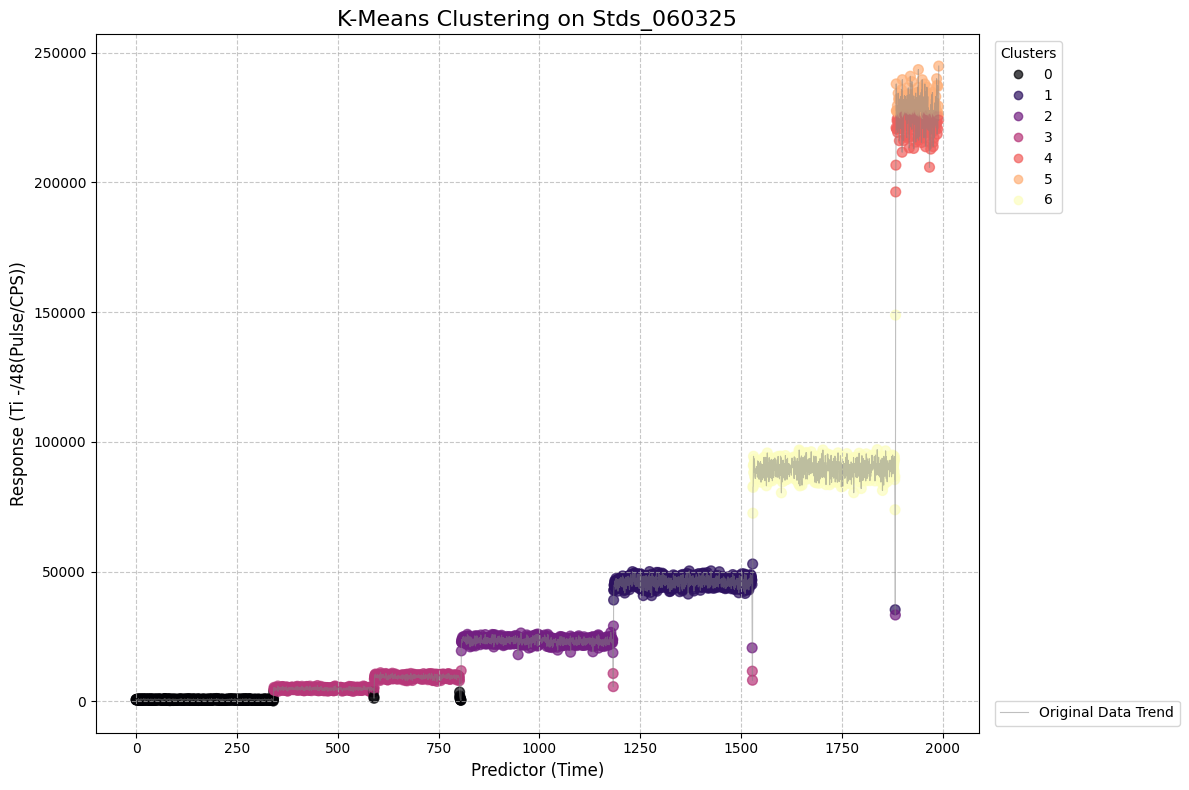

In [60]:
# 1. Create the figure and axes
fig, ax1 = plt.subplots(figsize=(12, 8), layout='constrained') # Increased figure size for clarity

# 2. Plot the original line data on ax1
ax1.plot(df_km['Time'], df_km[response], color='gray', linestyle='-', linewidth=0.8, alpha=0.5, label='Original Data Trend')

# 3. Plot the clustered data points on ax1
# Ensure df_km.iloc[:, 0] maps to 'Time' 
# df_km.iloc[:, 1] maps to 'response'

scatter = ax1.scatter(df_km.iloc[:, 0], df_km.iloc[:, 1],
                      c=labels, cmap='magma', s=50, alpha=0.7, label='Clustered Data Points')

# 5. Set title and labels
ax1.set_title(f'K-Means Clustering on {dataset_name}', fontsize=16)
ax1.set_xlabel('Predictor (Time)', fontsize=12)
ax1.set_ylabel(f'Response ({response})', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)

# 6. Create legends
# Legend for clustered data points (colors)
legend1 = ax1.legend(*scatter.legend_elements(), title="Clusters", loc="upper left", bbox_to_anchor=(1.01, 1))
ax1.add_artist(legend1) # Add this legend back to the axes

# Legend for the original data line and centroids
# Create custom handles for these
line_legend_handle = plt.Line2D([], [], color='gray', linestyle='-', linewidth=0.8, alpha=0.5, label='Original Data Trend')

ax1.legend(handles=[line_legend_handle], loc="lower left", bbox_to_anchor=(1.01, 0))

# Ensure layout is tight, preventing labels from being cut off
fig.tight_layout()
plt.show()

In [ ]:
# Assuming 'df_km' contains your original data with the time column and 'labels'
# is the output from your KMeans clustering (e.g., kmeans.labels_)

cluster_intervals = {}
for cluster_id in sorted(set(labels)):
    # Get the time values for points belonging to this cluster
    times_in_cluster = df_km.iloc[labels == cluster_id, 0]
    # times_in_cluster = times_in_cluster[times_in_cluster.index <= changes_at]
    if not times_in_cluster.empty:
        min_time = times_in_cluster.min()
        max_time = times_in_cluster.max()
        cluster_intervals[cluster_id] = (min_time, max_time)


We'll map out the intervals that were identified here. 

In [80]:
detected_intervals = sorted(list(cluster_intervals.values()))
interval_areas = {}
detected_intervals


[(np.float64(0.0), np.float64(341.292))]

We can plot the distribution to see a good value to drop at. For now, anything below 90 will not have its outliers dropped.

Let's now remove outliers by the given region. We can use the `remove_outliers_by_region` function defined in the `OutlierUtils` module. 

[(np.float64(0.0), np.float64(805.709)),
 (np.float64(341.724), np.float64(1528.472)),
 (np.float64(806.573), np.float64(1882.725)),
 (np.float64(1184.155), np.float64(1882.293)),
 (np.float64(1529.336), np.float64(1883.157)),
 (np.float64(1883.589), np.float64(1989.865)),
 (np.float64(1884.885), np.float64(1990.297))]

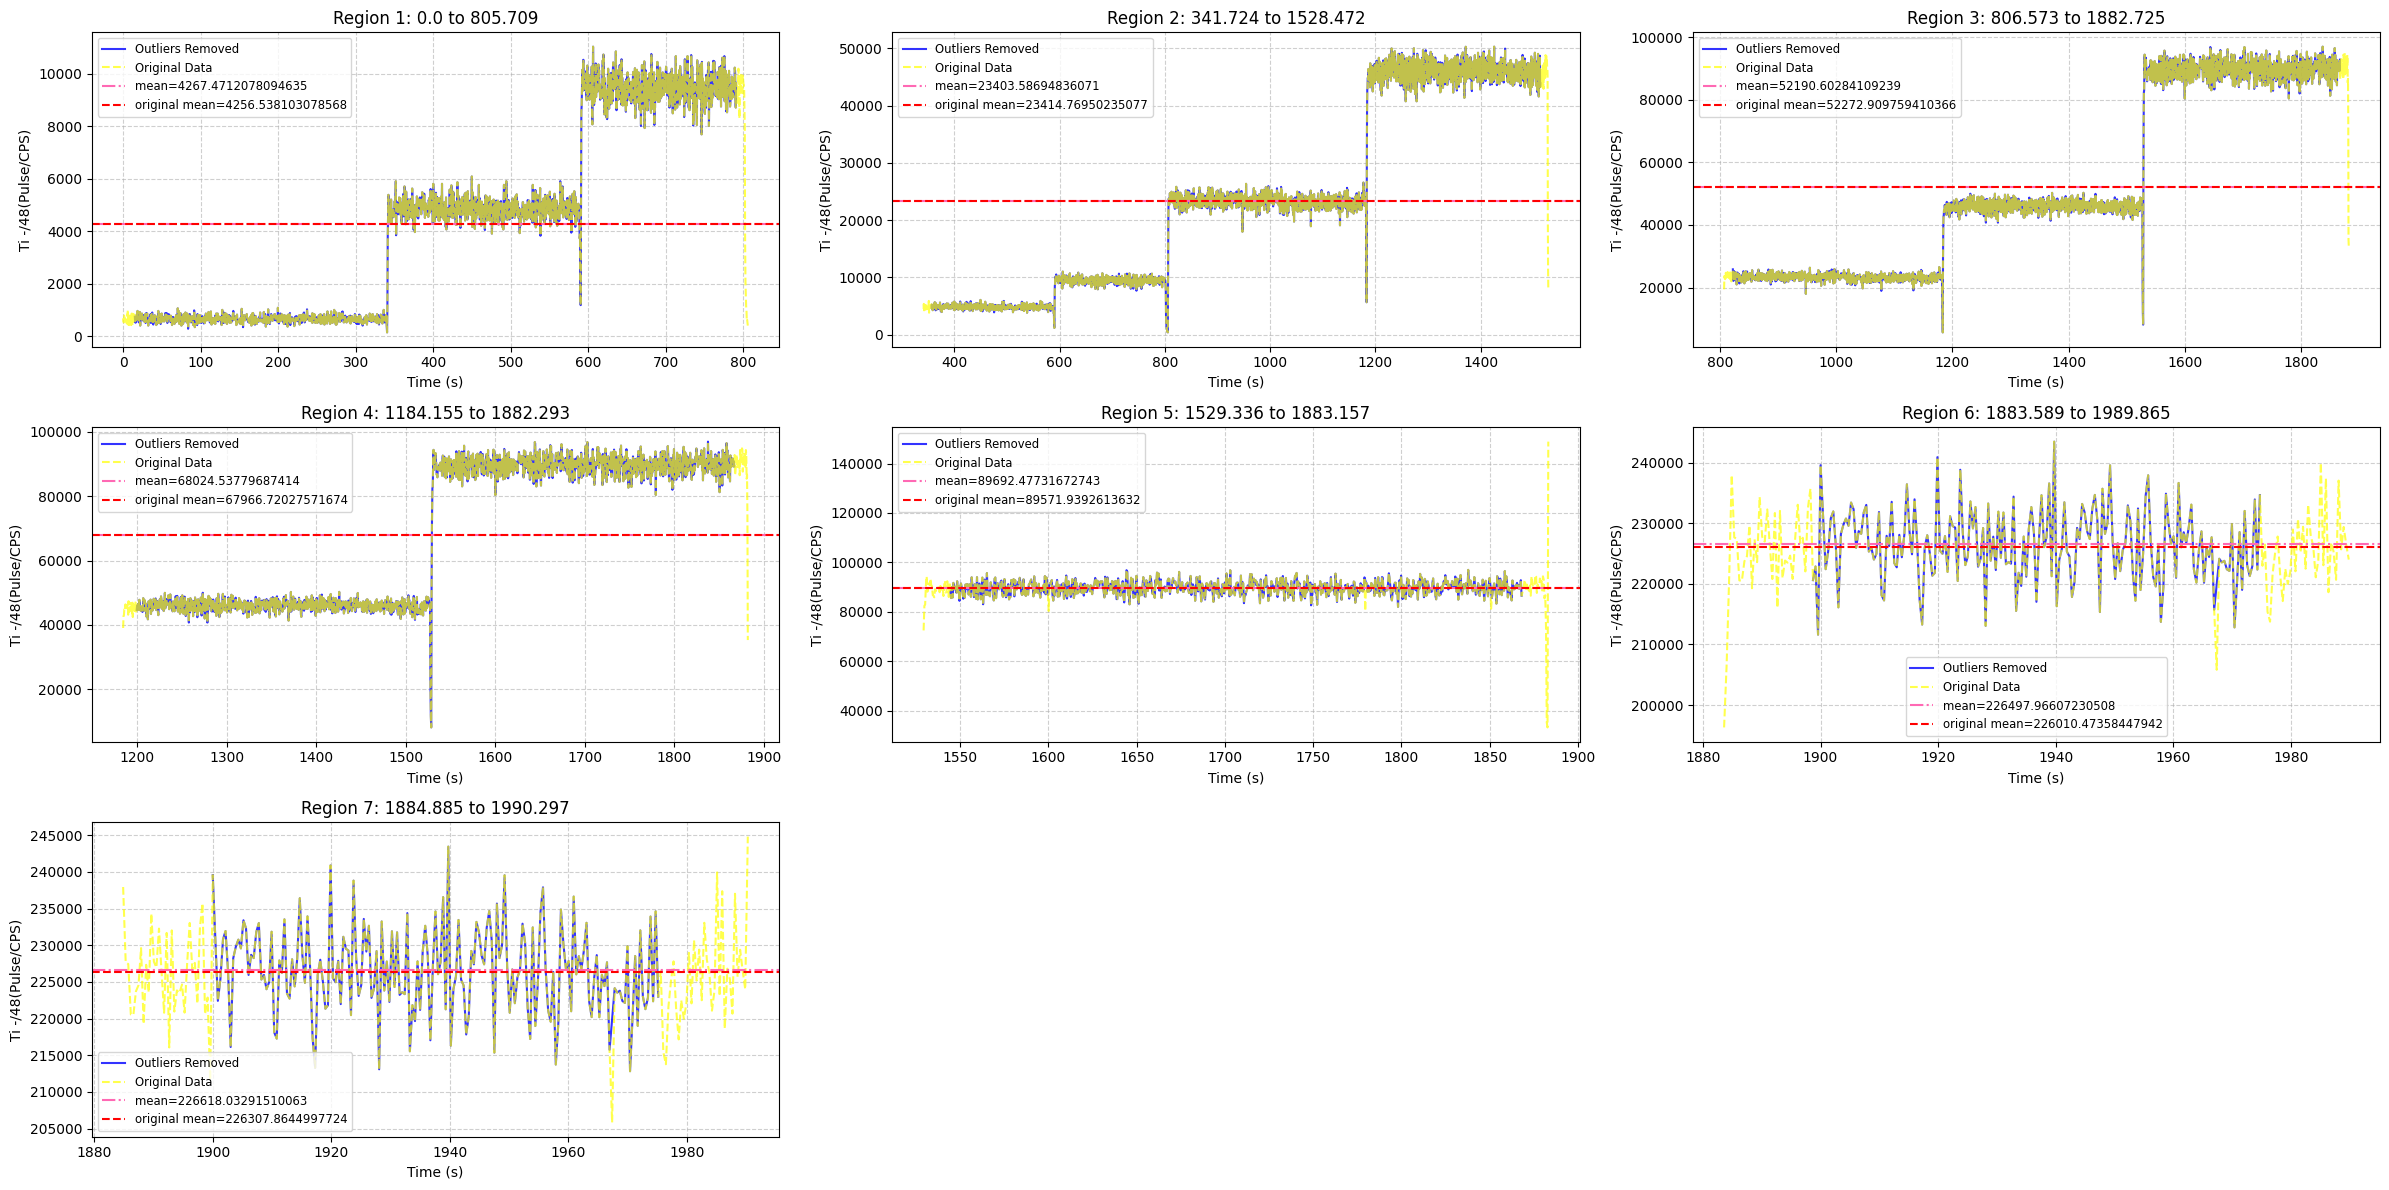

In [42]:
regional_means = []

num_regions = len(detected_intervals)
ncols = 3 # You can change the number of columns
nrows = (num_regions + ncols - 1) // ncols

offset = 15 # 15 seconds offset to 

final_df = pd.DataFrame()


fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24, 4 * nrows))
axes_flat = axes.flatten() # Flatten the 2D axes array for easier iteration
display(detected_intervals)
for i, (x0, x1) in enumerate(detected_intervals):
    # Get the current Axes object for this iteration from the flattened array
    if i < len(axes_flat):
        current_ax = axes_flat[i]
    else:
        # This case should ideally not happen if nrows is calculated correctly,
        # but provides a safeguard if more plots are attempted than subplots available.
       logging.warning(f" Not enough subplots for region {i+1}. Skipping plot.")
        continue
    

    # Call your outlier removal function for the current region
    Y_prime = remove_outliers_by_region(R=[x0 + offset, x1 - offset], response_column_name=response, Y=df)
    
    # print(f'New Region {i+1}: ({val['Start'] + offset}, {val['End'] - offset})')

    # Plot the results on the current subplot
    if not Y_prime.empty:
        # Plot the data after outlier removal
        current_ax.plot(Y_prime['Time'], Y_prime[response], label='Outliers Removed', color='blue', alpha=0.8)
        
        # Plot original data for comparison (only within the current region)

        original_region_data = df[(df['Time'] >= x0) & (df['Time'] <= x1)]
        
        
        current_ax.plot(original_region_data['Time'], original_region_data[response],
                        '--', color='yellow', alpha=0.7, label='Original Data')
        
        region_mean = Y_prime[response].mean()
        original_mean = original_region_data[response].mean()
        
        current_ax.axhline(y=region_mean, color='#FF69B4', linestyle='-.', label=f'mean={region_mean}')
        current_ax.axhline(y=original_mean, color='red', linestyle='--', label=f'original mean={original_mean}')

        regional_means.append(region_mean)
        
        current_ax.legend(fontsize='small')
    else:
        current_ax.text(0.5, 0.5, 'No Data or Outliers Removed\nfor this Region',
                        horizontalalignment='center', verticalalignment='center',
                        transform=current_ax.transAxes, fontsize=10, color='red')

    # Set titles and labels for the current subplot
    current_ax.set_title(f'Region {i+1}: {x0} to {x1}')
    current_ax.set_xlabel('Time (s)')
    current_ax.set_ylabel(f'{response}')
    current_ax.grid(True, linestyle='--', alpha=0.6) # Add a grid for better readability

    final_df = pd.concat([final_df, Y_prime], ignore_index=True)



# This prevents empty plots from appearing if your `area_df` has fewer regions than the grid size
for j in range(num_regions, len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.savefig(f'{figure_dir}/regions.png',
             bbox_inches='tight',
             dpi=300)
plt.tight_layout() # Automatically adjust subplot parameters for a tight layout
plt.show() # Display the plot
    
# plt.tight_layout()
# plt.show()

In [43]:
final_df = final_df.sort_index()

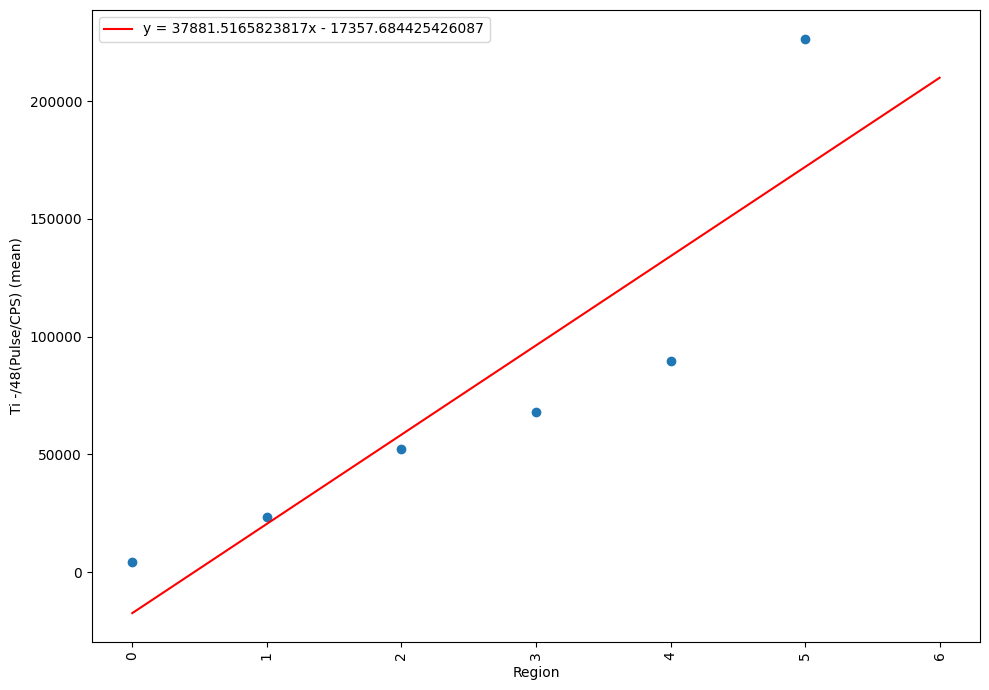

In [44]:
# Start plotting regional means
# Assuming area_df is already defined as a Series

# Drop last region if not near mean of other sections


labels = np.arange(len(regional_means))
fig, ax1 = plt.subplots(figsize=(10, 7))

# Plot the bars
ax1.scatter(labels[:-1], regional_means[:-1])  # Convert index to string for proper label display
m,b = np.polyfit(labels[:-1], regional_means[:-1], 1)
np.polyfit

if b >= 0:
    line_label = f'y = {m}x + {b}'
else:
    line_label = f'y = {m}x - {-b}' # Use -b to show a positive number after the minus sign

ax1.plot(labels, m*labels + b, color='red', label=line_label)

plt.legend()

ax1.set_xlabel('Region')
ax1.set_ylabel(f'{response} (mean)')

# Improve tick display
ax1.set_xticks(range(len(labels)))
ax1.set_xticklabels(labels,rotation=90)  # Rotate for better readability
plt.tight_layout()
plt.savefig(f'{figure_dir}/regression.png', bbox_inches='tight',dpi=300)
plt.show()



$$ \textit{Opus ex amino, } \\ \text{Bhagawat Chapagain} $$